In [3]:
##CUSTOM
!pip install matplotlib

import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv

def read_video_frames(video_path, resize_factor=1.0):  # Changed from 0.25
    """
    Reads frames from a video and converts them to grayscale.
    Optionally resizes frames to speed up processing.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    pbar = tqdm(desc="Reading Frames", unit="frame")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if resize_factor != 1.0:
            gray = cv2.resize(gray, (0, 0), fx=resize_factor, fy=resize_factor)
        frames.append(gray)
        pbar.update(1)
    cap.release()
    pbar.close()
    return frames

def compute_tad(frame1, frame2):
    """
    Computes Total Absolute Difference (TAD) between two grayscale frames.
    """
    return np.sum(np.abs(frame1.astype(np.int32) - frame2.astype(np.int32)))

def plot_tad_series(tads, threshold, output_path="tad_plot.png"):
    """
    Plots the TAD values over frame indices and saves the figure.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(tads, label="TAD per frame")
    plt.axhline(y=threshold, color='r', linestyle='--', label='TAD Threshold')
    plt.title("Total Absolute Difference (TAD) Over Frames")
    plt.xlabel("Frame Index")
    plt.ylabel("TAD Value")
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"✅ TAD plot saved as {output_path}")

def detect_transitions(video_path, tad_threshold=None):
    """
    Detects candidate transitions based on TAD exceeding a threshold.
    Returns the first 5 candidate indices and the full frame list.
    """
    frames = read_video_frames(video_path, resize_factor=1.0)
    print(f"Total frames read: {len(frames)}")
    
    tads = []
    candidate_indices = []

    print("Computing TADs...")
    for i in tqdm(range(len(frames) - 1), desc="TAD Loop"):
        tad = compute_tad(frames[i], frames[i + 1])
        tads.append(tad)

    # Show some TAD stats
    print(f"🔍 Max TAD: {np.max(tads):.2e}, Min TAD: {np.min(tads):.2e}, Mean TAD: {np.mean(tads):.2e}")

    # Auto-threshold if not set
    if tad_threshold is None:
        tad_threshold = np.mean(tads) + 2 * np.std(tads)
        print(f"📈 Auto-selected threshold: {tad_threshold:.2e}")

    for i, tad in enumerate(tads):
        if tad > tad_threshold:
            candidate_indices.append(i)
    
    print(f"🎯 Candidate transitions found: {len(candidate_indices)}")
    plot_tad_series(tads, tad_threshold)

    # Save all TADs for analysis
    with open("tad_values.csv", "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Frame Index", "TAD"])
        for i, val in enumerate(tads):
            writer.writerow([i, val])
    print("📊 TAD values saved to tad_values.csv")

    return candidate_indices[:5], frames  # Return only first 5 candidates

def save_results(transition_indices, frames, output_folder="output_frames", txt_file="transitions.txt"):
    """
    Saves the selected transition frames as images and logs their indices in a text file.
    """
    os.makedirs(output_folder, exist_ok=True)
    with open(txt_file, "w") as f:
        f.write("Saved Candidate Transitions:\n")
        for idx in transition_indices:
            f.write(f"Frame {idx}\n")
            img = frames[idx]
            cv2.imwrite(os.path.join(output_folder, f"frame_{idx:05d}.png"), img)
    print(f"📝 Transition frames saved in '{output_folder}/' and logged in '{txt_file}'")

# ------------------------ Main ------------------------

# ------------------------ Main ------------------------

if __name__ == "__main__":
    VIDEO_PATH = "/Users/ahsenbeyzaozkul/SPRING2025/BLG202E/PROJECT/video1.mov"  # or video1.mov
    print("🎬 Starting transition detection...")

    # First read frames and compute TADs without filtering
    frames = read_video_frames(VIDEO_PATH)
    print(f"Total frames read: {len(frames)}")

    tads = []
    for i in tqdm(range(len(frames) - 1), desc="Computing TADs"):
        tad = compute_tad(frames[i], frames[i + 1])
        tads.append(tad)

    mean_tad = np.mean(tads)
    std_tad = np.std(tads)
    adaptive_threshold = mean_tad + 3 * std_tad  # Try 2 or 2.5 if too sensitive

    print(f"📈 Adaptive TAD Threshold set to: {adaptive_threshold:.2e}")
    plot_tad_series(tads, adaptive_threshold)

    candidate_indices = [i for i, tad in enumerate(tads) if tad > adaptive_threshold]
    print(f"🎯 Candidate transitions found: {len(candidate_indices)}")

    # Save data
    with open("tad_values.csv", "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Frame Index", "TAD"])
        for i, val in enumerate(tads):
            writer.writerow([i, val])
    print("📊 TAD values saved to tad_values.csv")

    # Save top 5 transitions
    save_results(candidate_indices[:5], frames)
    print("✅ Candidate frames saved:", candidate_indices[:5])


🎬 Starting transition detection...


Reading Frames: 846frame [00:01, 543.53frame/s]


Total frames read: 846


Computing TADs: 100%|███████████████████████████████████████████████████████████████| 845/845 [00:00<00:00, 1008.22it/s]


📈 Adaptive TAD Threshold set to: 1.63e+07
✅ TAD plot saved as tad_plot.png
🎯 Candidate transitions found: 5
📊 TAD values saved to tad_values.csv
📝 Transition frames saved in 'output_frames/' and logged in 'transitions.txt'
✅ Candidate frames saved: [149, 299, 449, 621, 747]


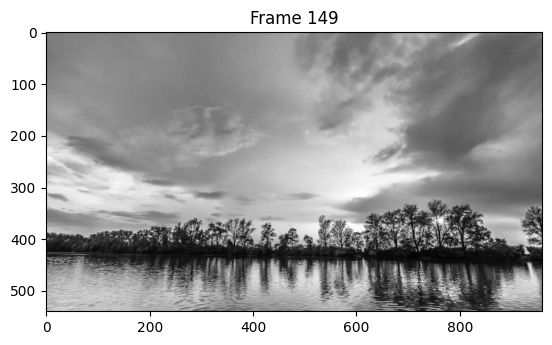

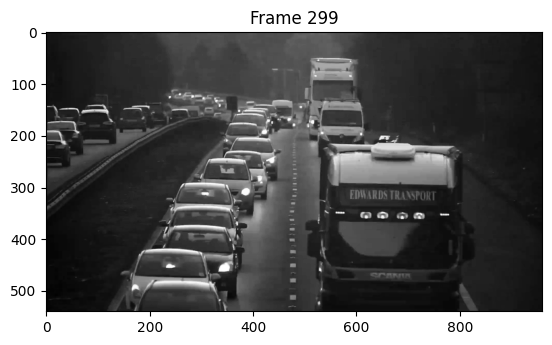

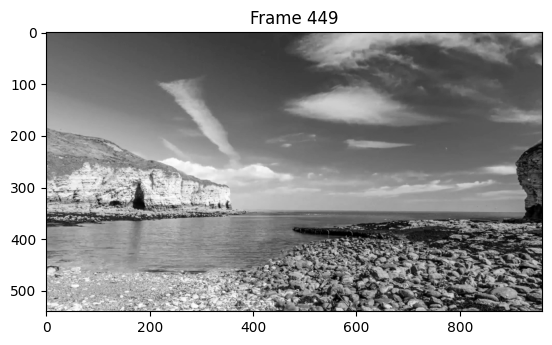

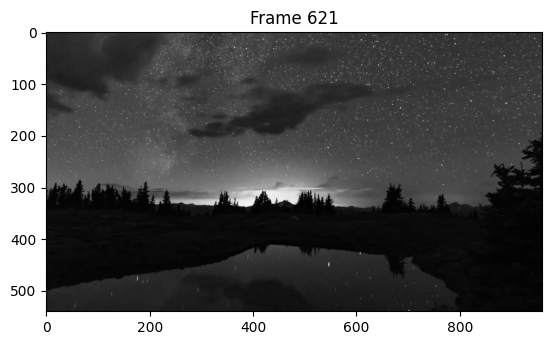

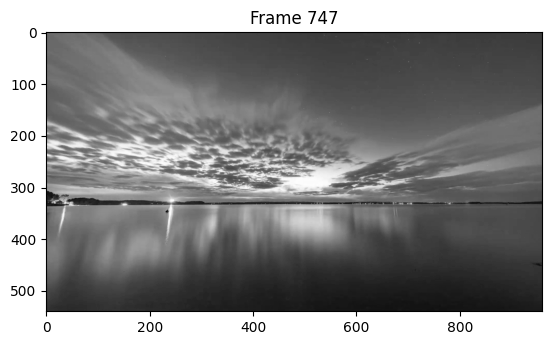

In [6]:
# DEBUG: Check a few sample frames
import matplotlib.pyplot as plt

sample_indexes = [149, 299, 449, 621, 747]  # Adjust based on your video length
for idx in sample_indexes:
    if idx < len(frames):
        plt.imshow(frames[idx], cmap='gray')
        plt.title(f"Frame {idx}")
        plt.show()

In [7]:
##BUILTIN ONE

import cv2
import os

def read_frames(video_path, resize_factor=0.5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if resize_factor != 1.0:
            gray = cv2.resize(gray, (0, 0), fx=resize_factor, fy=resize_factor)
        frames.append(gray)
    cap.release()
    return frames

def compute_difference(frame1, frame2):
    # Use simple mean absolute difference
    diff = cv2.absdiff(frame1, frame2)
    return diff.mean()

def detect_transitions(frames, threshold):
    candidate_indices = []
    for i in range(len(frames) - 1):
        diff = compute_difference(frames[i], frames[i + 1])
        if diff > threshold:
            candidate_indices.append(i)
    return candidate_indices

def save_candidate_frames(indices, frames, output_folder="simple_output"):
    os.makedirs(output_folder, exist_ok=True)
    for idx in indices:
        cv2.imwrite(os.path.join(output_folder, f"frame_{idx:05d}.png"), frames[idx])

# ---------------------- MAIN -----------------------
if __name__ == "__main__":
    VIDEO_PATH = "/Users/ahsenbeyzaozkul/SPRING2025/BLG202E/PROJECT/video1.mov"  # Update your path
    THRESHOLD = 25  # You may need to adjust based on video (try 10–30 range)

    print("Reading video frames...")
    frames = read_frames(VIDEO_PATH)
    print(f"Total frames: {len(frames)}")

    print("Detecting transitions...")
    transitions = detect_transitions(frames, THRESHOLD)
    print(f"Found {len(transitions)} transitions at frames:", transitions)

    print("Saving candidate transition frames...")
    save_candidate_frames(transitions, frames)
    print("Done ✅")


Reading video frames...
Total frames: 846
Detecting transitions...
Found 5 transitions at frames: [149, 299, 449, 621, 747]
Saving candidate transition frames...
Done ✅


In [ ]:
pip install seaborn


In [12]:
!pip install notebook


import json
import os
from notebook import notebookapp
import ipykernel
from urllib.parse import urljoin

connection_file = os.path.basename(ipykernel.get_connection_file())
kernel_id = connection_file.split('-', 1)[1].split('.')[0]
print("Kernel ID:", kernel_id)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 2.8 MB/s eta 0:00:0000:0100:01


ImportError: cannot import name 'notebookapp' from 'notebook' (/Users/ahsenbeyzaozkul/miniconda3/envs/video_svd/lib/python3.9/site-packages/notebook/__init__.py)

In [13]:
pip install jupyter_server


Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import json
import ipykernel
from jupyter_server import serverapp

connection_file = os.path.basename(ipykernel.get_connection_file())
kernel_id = connection_file.split('-', 1)[1].split('.')[0]
print("Kernel ID:", kernel_id)

for srv in serverapp.list_running_servers():
    print("URL:", srv['url'])
    print("Token:", srv.get('token', ''))


Kernel ID: 96a28eb6-b259-4e59-9d2d-5230a710679c
URL: http://localhost:8888/
Token: f3ebee68845ea0a73ea918640c07f07c96e4bf5660dc51f4
